In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from annotation_utilities import contours_to_mask
from registration_utilities import find_contour_points

import numpy as np

sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.morphology import remove_small_objects, disk, remove_small_holes, binary_dilation
from skimage.io import imread, imsave
from skimage.util import img_as_ubyte
from skimage.segmentation import slic, mark_boundaries
from skimage.future.graph import rag_mean_color, cut_normalized, cut_threshold
from skimage.color import label2rgb

from scipy.stats import entropy

from scipy.sparse.linalg import ArpackError

Setting environment for Gordon


No vtk


In [9]:
fn = 'MD653-F42-2016.12.21-04.36.51_MD653_2_0125'
stack = 'MD653'

In [10]:
submask_dir = create_if_not_exists(os.path.join(DATA_DIR, '%(stack)s/%(stack)s_submasks/%(fn)s' % \
                                                {'fn':fn, 'stack':stack}))
execute_command('rm -f %s/*' % submask_dir)

rm -f /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD653/MD653_submasks/MD653-F42-2016.12.21-04.36.51_MD653_2_0125/*


Child returned 0


0

In [11]:
input_dir = '/home/yuncong/CSHL_data/%(stack)s' % dict(stack=stack)

In [12]:
VMAX_PERCENTILE = 99
VMIN_PERCENTILE = 1

In [13]:
tb_fmt = 'png'

In [14]:
img_rgb = imread(os.path.join(input_dir, '%(fn)s.%(tb_fmt)s' % dict(fn=fn, tb_fmt=tb_fmt)))

# Don't use blue channel, dim bright at the background; the other channels are in fact more contrasty.
rmax = img_rgb[..., 0].max()
rmin = img_rgb[..., 0].min()
rrange = rmax - rmin
gmax = img_rgb[..., 1].max()
gmin = img_rgb[..., 1].min()
grange = gmax - gmin
bmax = img_rgb[..., 2].max()
bmin = img_rgb[..., 2].min()
brange = bmax - bmin

rborder = np.median(np.r_[img_rgb[:10, :, 0].flatten(),
                                     img_rgb[-10:, :, 0].flatten(),
                                     img_rgb[:, :10, 0].flatten(),
                                     img_rgb[:, -10:, 0].flatten()])
gborder = np.median(np.r_[img_rgb[:10, :, 1].flatten(),
                                     img_rgb[-10:, :, 1].flatten(),
                                     img_rgb[:, :10, 1].flatten(),
                                     img_rgb[:, -10:, 1].flatten()])
bborder = np.median(np.r_[img_rgb[:10, :, 2].flatten(),
                                     img_rgb[-10:, :, 2].flatten(),
                                     img_rgb[:, :10, 2].flatten(),
                                     img_rgb[:, -10:, 2].flatten()])

r_std = np.std(img_rgb[..., 0])
g_std = np.std(img_rgb[..., 1])
b_std = np.std(img_rgb[..., 2])

r_ent = entropy(img_rgb[..., 0].flat)
g_ent = entropy(img_rgb[..., 1].flat)
b_ent = entropy(img_rgb[..., 2].flat)

print rmax,rmin,rrange,rborder,r_std,r_ent
print gmax,gmin,grange,gborder,g_std,g_ent
print bmax,bmin,brange,bborder,b_std,b_ent

255 0 255 6.0 14.2969974802 13.7666256477
255 0 255 8.0 19.8391021284 13.7634521909
255 0 255 8.0 59.1417410214 13.4602146606


In [147]:
# fig, axes = plt.subplots(3, 1, sharex=True)

# axes[0].hist(img_rgb[..., 0].flatten(), bins=np.arange(0,255));
# axes[0].set_title('Red, std %f' % r_var);

# axes[1].hist(img_rgb[..., 1].flatten(), bins=np.arange(0,255));
# axes[1].set_title('Green, std %f' % g_var);

# axes[2].hist(img_rgb[..., 2].flatten(), bins=np.arange(0,255));
# axes[2].set_title('Blue, std %f' % b_var);

# plt.suptitle('Intensity');
# plt.tight_layout();
# plt.show();

In [15]:
if r_std > g_std:
    img = img_rgb[..., 0].copy() # G channel is better than R as R sometimes are contaminated on fluorescent slices.
    print 'Using RED channel.'
else:
    img = img_rgb[..., 1].copy() # G channel is better than R as R sometimes are contaminated on fluorescent slices.
    print 'Using GREEN channel.'
    
if rborder < 123 and gborder < 123 and bborder < 123:
    # dark background, fluorescent
    img = img.max() - img # invert, make tissue dark on bright background
    
# plt.figure(figsize=(20,20));
# plt.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)
# plt.title('Original');
# plt.show();

Using GREEN channel.


In [16]:
# Stretch contrast

img_flattened = img.flatten()

vmax_perc = VMAX_PERCENTILE
while vmax_perc > 80:
    vmax = np.percentile(img_flattened, vmax_perc)
    if vmax < 255:
        break
    else:
        vmax_perc -= 1

vmin_perc = VMIN_PERCENTILE
while vmin_perc < 20:
    vmin = np.percentile(img_flattened, vmin_perc)
    if vmin > 0:
        break
    else:
        vmin_perc += 1
    
sys.stderr.write('%d(%d percentile), %d(%d percentile)\n' % (vmin, vmin_perc, vmax, vmax_perc) )

img[(img <= vmax) & (img >= vmin)] = 255./(vmax-vmin)*(img[(img <= vmax) & (img >= vmin)]-vmin)
img[img > vmax] = 255
img[img < vmin] = 0
img = img.astype(np.uint8)

# plt.figure(figsize=(20,20));
# plt.imshow(img, cmap=plt.cm.gray)
# plt.title('Contrast Stretched');
# plt.show();

162(1 percentile), 253(99 percentile)


In [17]:
# # Gamma correction.

# GAMMA = 1. # if gamma > 1, image is darker.
# img = img_as_ubyte(img_as_float(img)**GAMMA)

# plt.figure(figsize=(20,20));
# plt.imshow(img, cmap=plt.cm.gray)
# plt.title('Gamma Corrected');
# plt.show();

In [18]:
SLIC_SIGMA = 3
SLIC_COMPACTNESS = 10
SLIC_N_SEGMENTS = 200
SLIC_MAXITER = 100

In [19]:
# Input to slic() must be float

t = time.time()
slic_labels = slic(img.astype(np.float), sigma=SLIC_SIGMA, compactness=SLIC_COMPACTNESS, n_segments=SLIC_N_SEGMENTS, 
                   multichannel=False, max_iter=SLIC_MAXITER)
sys.stderr.write('SLIC: %.2f seconds.\n' % (time.time() - t)) # 15 seconds

# slic_boundaries = mark_boundaries(img, label_img=slic_labels, background_label=-1)

# plt.figure(figsize=(20,20));
# plt.imshow(slic_boundaries);
# plt.show();

SLIC: 10.63 seconds.


In [20]:
SUPERPIXEL_SIMILARITY_SIGMA = 50. # higher value means greater affinity between superpixels.

In [21]:
# Build affinity graph.

t = time.time()
sim_graph = rag_mean_color(img, slic_labels, mode='similarity', sigma=SUPERPIXEL_SIMILARITY_SIGMA)
sys.stderr.write('Build affinity graph: %.2f seconds.\n' % (time.time() - t)) # 20 seconds

edge_weights = np.array([a['weight'] for n, d in sim_graph.adjacency_iter() for a in d.itervalues()])

# percentages = [np.count_nonzero(edge_weights < th) / float(len(edge_weights)) for th in np.linspace(0, 1, 100)]

# plt.plot(np.linspace(0, 1, 100), percentages);
# plt.title('Cumulative distribution of superpixel affinity');
# plt.xlabel('Edge affinity');
# plt.show();

Build affinity graph: 15.33 seconds.


In [22]:
SUPERPIXEL_MERGE_SIMILARITY_THRESH = .2
# threshold on affinity; edge whose affinity is above this value is not further split. 
# if edge affinity is below this value, do further split.
# Higher value means more sensitive to slight intensity difference.

GRAPHCUT_NUM_CUTS = 20

In [23]:
# Recursively perform binary normalized cut.

for _ in range(3):
    try:

        t = time.time()
        ncut_labels = cut_normalized(slic_labels, sim_graph, in_place=False, 
                                     thresh=SUPERPIXEL_MERGE_SIMILARITY_THRESH,
                                     num_cuts=GRAPHCUT_NUM_CUTS)

        sys.stderr.write('Normalized Cut: %.2f seconds.\n' % (time.time() - t)) # 1.5s for SLIC_N_SEGMENTS=200 ~ O(SLIC_N_SEGMENTS**3)
        break

    except ArpackError as e:
        sys.stderr.write('ArpackError encountered.\n')
        continue
    
ncut_boundaries_viz = mark_boundaries(img, label_img=ncut_labels, background_label=-1)

Normalized Cut: 0.88 seconds.


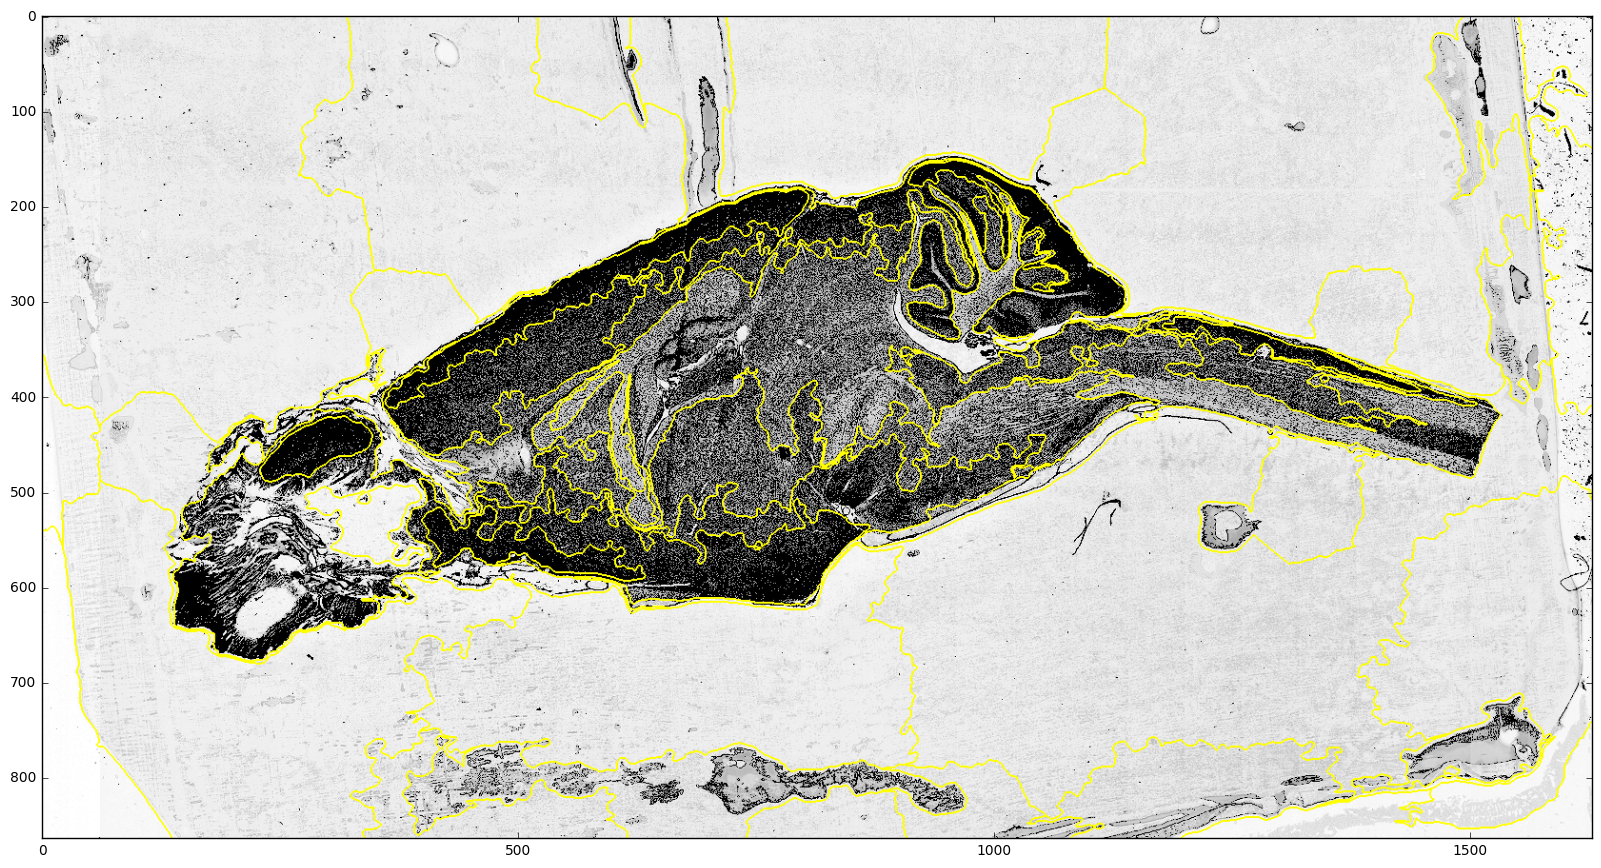

In [24]:
plt.figure(figsize=(20,20));
plt.imshow(ncut_boundaries_viz);
plt.show();

In [25]:
# Find background superpixels.

background_labels = np.unique(np.concatenate([ncut_labels[:,0], ncut_labels[:,-1], 
                                              ncut_labels[0,:], ncut_labels[-1,:]]))

In [26]:
BORDER_DISSIMILARITY_PERCENTILE = 30
MIN_SIZE = 1000

In [27]:
# Collect border superpixels.

border_histos = []
for b in background_labels:
    histo = np.histogram(img[ncut_labels == b], bins=np.arange(0,256,5))[0].astype(np.float)
    histo = histo/np.sum(histo)
    border_histos.append(histo)
    
# for histo in train_histos:
#     plt.bar(np.arange(0,255,5)[:-1], histo);
#     plt.show();

# Compute dissimilarity of superpixels to border superpixels.

histos = {}
for l in np.unique(ncut_labels):
    histo = np.histogram(img[ncut_labels == l], bins=np.arange(0,256,5))[0].astype(np.float)
    histo = histo/np.sum(histo)
    histos[l] = histo
    
hist_distances = {}
for l, h in histos.iteritems():
    hist_distances[l] = np.percentile([chi2(h, th) for th in border_histos], BORDER_DISSIMILARITY_PERCENTILE)
    # min is too sensitive if there is a blob at the border
    
# plt.hist(hist_distances.values(), bins=np.arange(0,2,.005));
# plt.title('Superpixel dissimilarity to border superpixels');
# plt.xlabel('Chi2 distance');
# plt.show();

dist_vals = np.asarray(hist_distances.values())
ticks = np.linspace(0, dist_vals.max(), 100)

percentages = [np.count_nonzero(dist_vals < th) / float(len(dist_vals)) for th in ticks]


# plt.plot(ticks, percentages);
# plt.title('Cumulative Distribution of Superpixel dissimilarity to border superpixels');
# plt.ylabel('Percentage');
# plt.xlabel('Chi2 distance');
# plt.show();

In [28]:
FOREGROUND_DISSIMILARITY_THRESHOLD_MAX = 1.5
INIT_CONTOUR_COVERAGE_MAX = .5

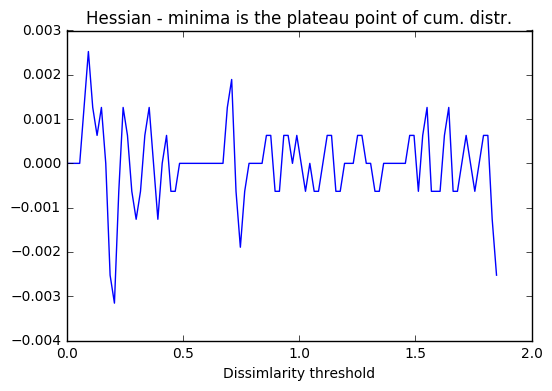

[ 0.20542419  0.74699705  0.39217345  0.29879882  1.34459469  1.32591977
  0.28012389  0.22409912  0.72832213  1.17652036]
FOREGROUND_DISSIMILARITY_THRESHOLD = 0.205424189471


In [29]:
# Strategy: Select the lowest threshold (most inclusive) while covers less than 50% of the image (avoid over-inclusiveness).

# Identify the leveling point
h = np.gradient(np.gradient(percentages, 3), 3)

plt.plot(ticks, h);
plt.title('Hessian - minima is the plateau point of cum. distr.');
plt.xlabel('Dissimlarity threshold');
plt.savefig(os.path.join(submask_dir, '%(fn)s_spDissimCumDistHessian.png' % dict(fn=fn)));
plt.show()

ticks_sorted = ticks[h.argsort()]
# ticks_sorted = ticks[find_score_peaks(-h, min_distance=5)[0]]
ticks_sorted_reduced = ticks_sorted[ticks_sorted < FOREGROUND_DISSIMILARITY_THRESHOLD_MAX]

init_contour_percentages = np.asarray([np.sum([np.count_nonzero(ncut_labels == l) 
                                               for l, d in hist_distances.iteritems() 
                                               if d > th]) / float(img.size) 
                                       for th in ticks_sorted_reduced])

threshold_candidates = ticks_sorted_reduced[(init_contour_percentages < INIT_CONTOUR_COVERAGE_MAX) &\
                                                          (init_contour_percentages > 0)]
np.savetxt(os.path.join(submask_dir, '%(fn)s_spThreshCandidates.txt' % dict(fn=fn)), threshold_candidates, fmt='%.3f')

print threshold_candidates[:10]
FOREGROUND_DISSIMILARITY_THRESHOLD = threshold_candidates[0]

print 'FOREGROUND_DISSIMILARITY_THRESHOLD =', FOREGROUND_DISSIMILARITY_THRESHOLD

In [176]:
# FOREGROUND_DISSIMILARITY_THRESHOLD = .2

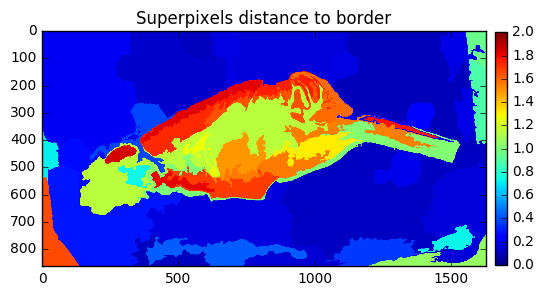

In [30]:
superpixel_border_distances = np.zeros_like(img, np.float)
for l, s in hist_distances.iteritems():
    superpixel_border_distances[ncut_labels == l] = s
    
# plt.figure(figsize=(20,20));
im = plt.imshow(superpixel_border_distances, vmin=0, vmax=2);
plt.title('Superpixels distance to border');
plt.colorbar(im, fraction=0.025, pad=0.02);

plt.savefig(os.path.join(submask_dir, '%(fn)s_spBorderDissim.png' % dict(fn=fn)));

In [31]:
# Generate mask for snake's initial contours.

# t = time.time()

superpixel_mask = np.zeros_like(img, np.bool)
for l, d in hist_distances.iteritems():
    if d > FOREGROUND_DISSIMILARITY_THRESHOLD:
        superpixel_mask[ncut_labels == l] = 1
        
# sys.stderr.write('Get mask from foreground superpixels: %.2f seconds.\n' %  (time.time() - t)) # 50 seconds.

In [32]:
labelmap, n_submasks = label(superpixel_mask, return_num=True)

In [33]:
superpixel_submasks = []
dilated_superpixel_submasks = []

for i in range(1, n_submasks+1):
    m = labelmap == i
    superpixel_submasks.append(m)
    
    dilated_m = binary_dilation(m, disk(10))
    dilated_m = remove_small_objects(remove_small_holes(dilated_m, min_size=2000), min_size=MIN_SIZE)
    dilated_superpixel_submasks.append(dilated_m)

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


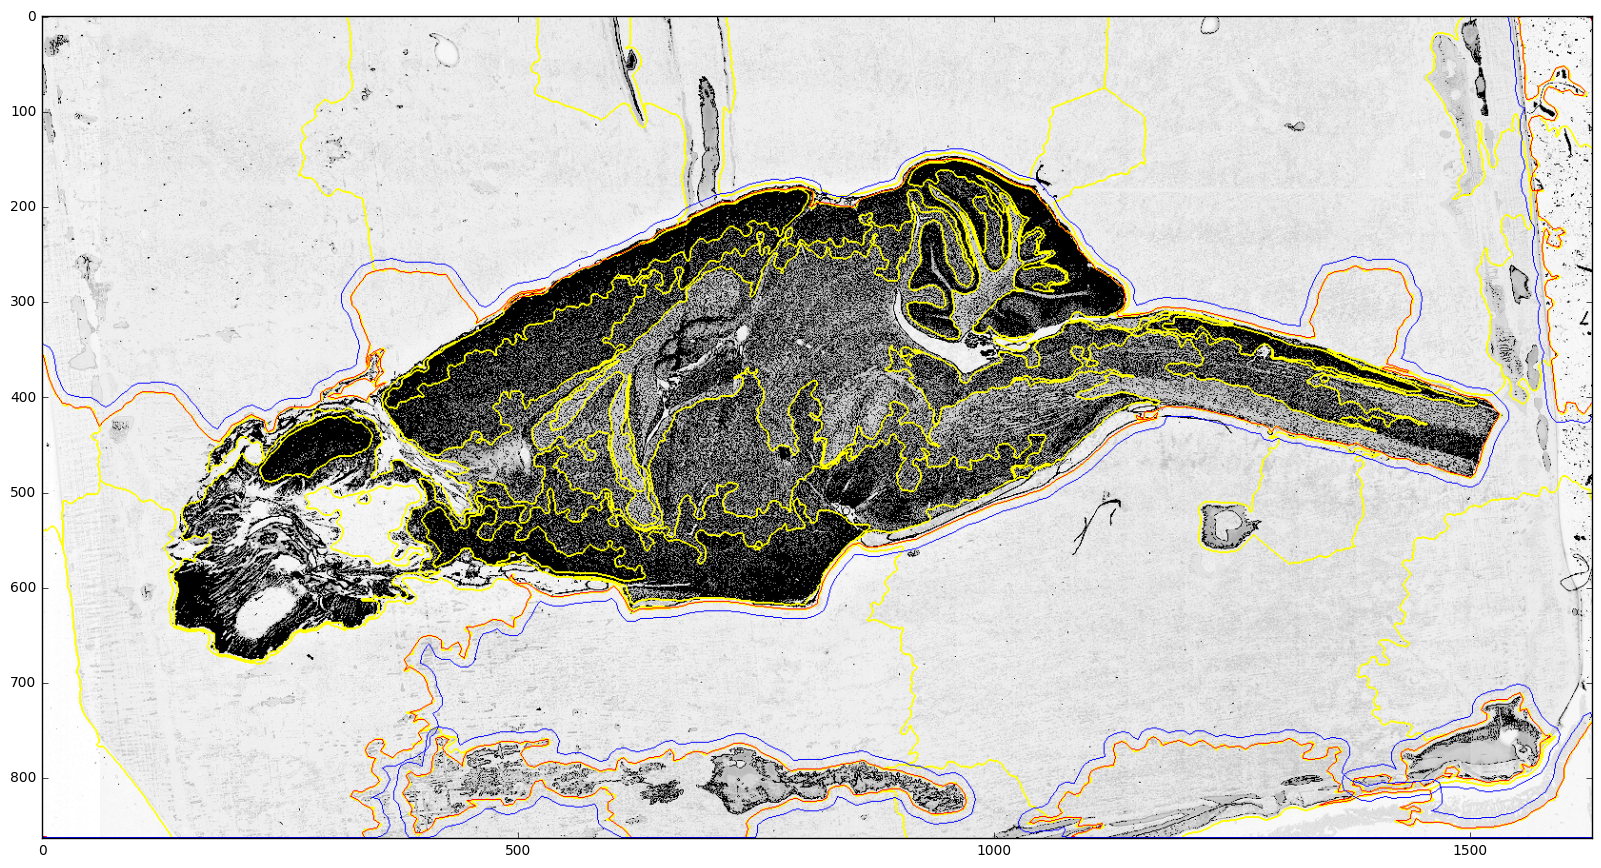

In [34]:
# Visualize

viz = img_as_ubyte(ncut_boundaries_viz)

for submask in superpixel_submasks:
    for cnt in find_contour_points(submask)[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (255,0,0), 1) # red

for submask in dilated_superpixel_submasks:
    for cnt in find_contour_points(submask)[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,0,255), 1) # blue
    
plt.figure(figsize=(20,20));
plt.imshow(viz);
plt.show();

In [35]:
img_enhanced = img

In [36]:
INIT_CONTOUR_MINLEN = 50

In [37]:
# Find contours from mask.

# orig_init_contours = [xys for xys in find_contour_points(superpixel_mask.astype(np.int), sample_every=1)[1] 
#                  if len(xys) > 50]

init_contours = [xys for submask in dilated_superpixel_submasks 
                 for xys in find_contour_points(submask.astype(np.int), sample_every=1)[1] 
                 if len(xys) > INIT_CONTOUR_MINLEN]

# assert len(init_contours) > 0, 'No contour is detected from entropy mask %s' % fn
sys.stderr.write('Extracted %d contours from mask.\n' % len(init_contours))

Extracted 5 contours from mask.


In [38]:
# Option 1: Morphsnake approach

# Create initial levelset

# from scipy.stats import entropy

init_levelsets = []
for cnt in init_contours:
    init_levelset = np.zeros_like(img, np.float)
    
    t = time.time()
    init_levelset[contours_to_mask([cnt], img.shape[:2])] = 1.
    sys.stderr.write('Contour to levelset: %.2f seconds\n' % (time.time() - t)) # 10s
    
    init_levelset[:10, :] = 0
    init_levelset[-10:, :] = 0
    init_levelset[:, :10] = 0
    init_levelset[:, -10:] = 0
    
#     plt.hist(img_rgb[init_levelset.astype(np.bool), 2], bins=np.arange(0,256));
#     plt.show();
    
#     val_entropy = entropy(img_rgb[init_levelset.astype(np.bool), 2])
#     sys.stderr.write('Entropy: %.2f.\n' % val_entropy)
    
#     val_std = np.std(img_rgb[init_levelset.astype(np.bool), 2])
#     sys.stderr.write('Contrast: %.2f.\n' % val_std)

#     if val_entropy < MIN_ENTROPY:
#         sys.stderr.write('Entropy too low, ignore.\n')
#         continue

#     if val_std < MIN_STD:
#         sys.stderr.write('Contrast too low, ignore.\n')
#         continue
    
    init_levelsets.append(init_levelset)

Contour to levelset: 0.13 seconds
Contour to levelset: 13.37 seconds
Contour to levelset: 0.05 seconds
Contour to levelset: 0.29 seconds
Contour to levelset: 0.28 seconds


In [39]:
MORPHSNAKE_SMOOTHING = 2
MORPHSNAKE_LAMBDA1 = .1 # Small lambda1 - less willing to break into dark regions. 
# imprtance of inside pixels
MORPHSNAKE_LAMBDA2 = 2 # Large = expand
# imprtance of outside pixels
MORPHSNAKE_MAXITER = 600
MORPHSNAKE_MINITER = 10
PIXEL_CHANGE_TERMINATE_CRITERIA = 3
AREA_CHANGE_RATIO_MAX = 1.1
AREA_CHANGE_RATIO_MIN = .1

In [40]:
#####################
# Evolve morphsnake #
#####################

import morphsnakes
from collections import deque

final_masks = []

for levelset_ind, init_levelset in enumerate(init_levelsets):
    
    sys.stderr.write('\nContour %d\n' % levelset_ind)

    discard = False
    init_area = np.count_nonzero(init_levelset)
    
    t = time.time()

#     msnake = morphsnakes.MorphACWE(img.astype(np.float), smoothing=int(MORPHSNAKE_SMOOTHING), 
#                                    lambda1=MORPHSNAKE_LAMBDA1, lambda2=MORPHSNAKE_LAMBDA2)
    
    msnake = morphsnakes.MorphACWE(img_enhanced.astype(np.float), smoothing=int(MORPHSNAKE_SMOOTHING), 
                                   lambda1=MORPHSNAKE_LAMBDA1, lambda2=MORPHSNAKE_LAMBDA2)
    
    msnake.levelset = init_levelset.copy()
    
    dq = deque([None, None])
    for i in range(MORPHSNAKE_MAXITER): 

        # At stable stage, the levelset (thus contour) will oscilate, 
        # so instead of comparing to previous levelset, must compare to the one before the previous
        oneBefore_levelset = dq.popleft()
    
        # If less than 3 pixels are changed, stop.
        if i > MORPHSNAKE_MINITER:
            if np.count_nonzero(msnake.levelset - oneBefore_levelset) < PIXEL_CHANGE_TERMINATE_CRITERIA:
                break
                
        area = np.count_nonzero(msnake.levelset)
                
        if area < MIN_SIZE:
            discard = True
            sys.stderr.write('Too small, stop iteration.\n')
            break
        
        # If area changes more than 2, stop.
        area_change_ratio = area/float(init_area)
#         sys.stderr.write('Area change: %.2f.\n' % area_change_ratio)
        if area_change_ratio > AREA_CHANGE_RATIO_MAX:
            discard = True
            sys.stderr.write('Area increases too much, stop iteration.\n')
            break  
        elif area_change_ratio < AREA_CHANGE_RATIO_MIN:
            discard = True
            sys.stderr.write('Area shrinks too much, stop iteration.\n')
            break
                
        dq.append(msnake.levelset)
        
#         t = time.time()
        msnake.step()
#         sys.stderr.write('Step: %f seconds\n' % (time.time()-t)) # 0.6 second/step, roughly 200 steps takes 120s
    
    sys.stderr.write('Snake finished at iteration %d.\n' % i)
    sys.stderr.write('Snake: %.2f seconds\n' % (time.time()-t)) # 72s
    
    if discard:
        sys.stderr.write('Discarded.\n')
        continue
    else:
        # Handles the case that a single initial contour morphs into multiple contours
        labeled_mask = label(msnake.levelset.astype(np.bool))
        for l in np.unique(labeled_mask):
            if l != 0:
                m = labeled_mask == l
                if np.count_nonzero(m) > MIN_SIZE:
                    final_masks.append(m)
                    sys.stderr.write('Final masks added.\n')


Contour 0
Area increases too much, stop iteration.
Snake finished at iteration 3.
Snake: 1.50 seconds
Discarded.

Contour 1
Snake finished at iteration 230.
Snake: 111.84 seconds
Final masks added.

Contour 2
Area increases too much, stop iteration.
Snake finished at iteration 3.
Snake: 1.44 seconds
Discarded.

Contour 3
Area increases too much, stop iteration.
Snake finished at iteration 3.
Snake: 1.46 seconds
Discarded.

Contour 4
Area increases too much, stop iteration.
Snake finished at iteration 4.
Snake: 1.93 seconds
Discarded.


# Export

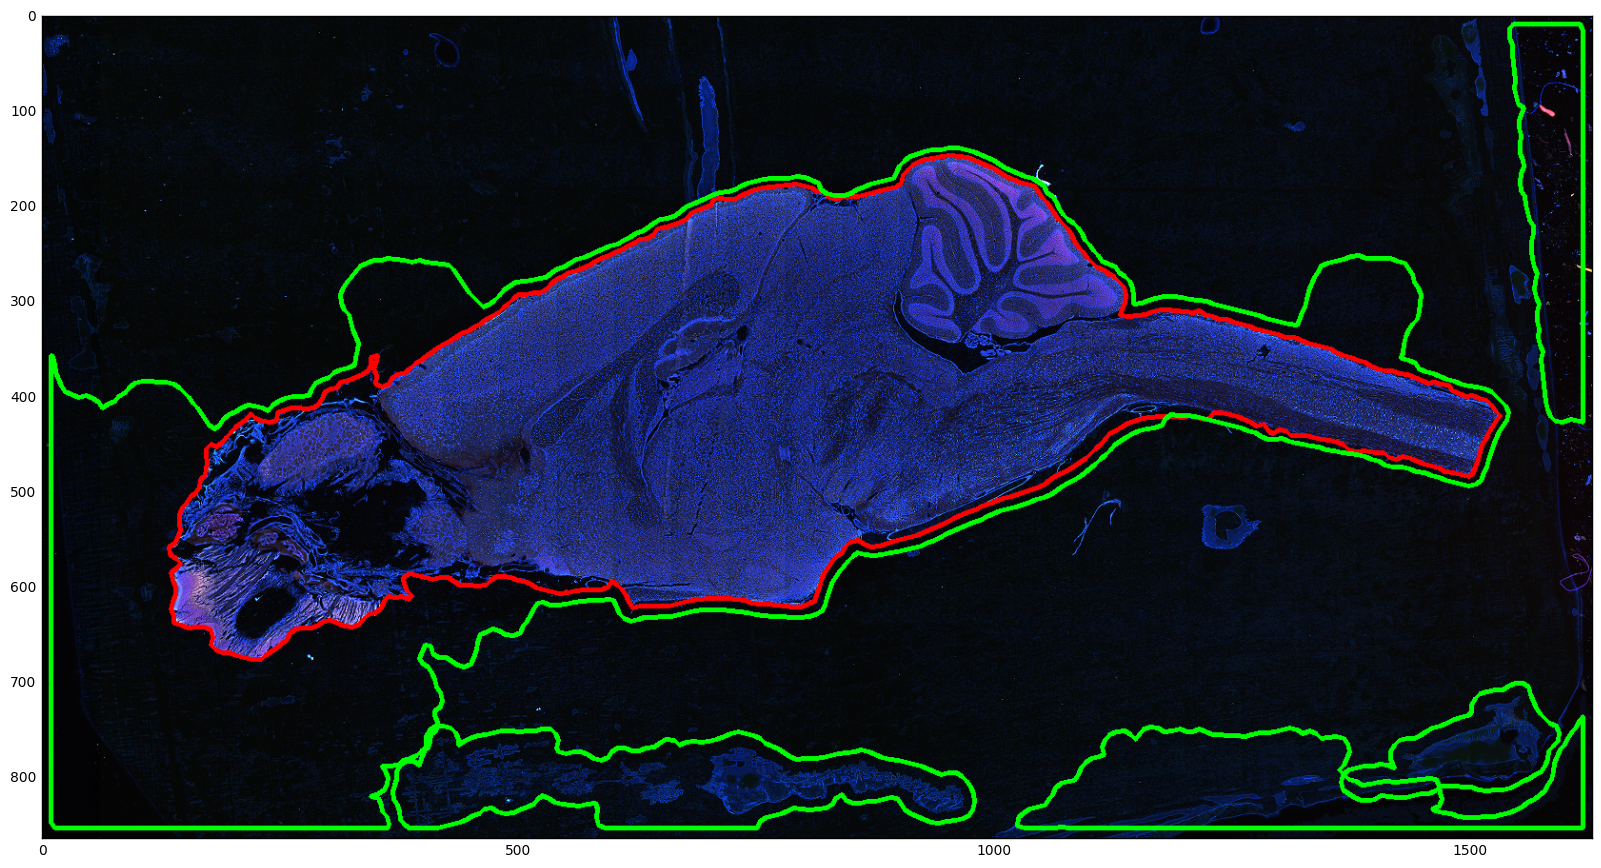

In [41]:
# submask_dir = create_if_not_exists('/home/yuncong/CSHL_data_processed/%(stack)s/%(stack)s_submasks/%(fn)s' % {'fn':fn, 'stack':stack})
# execute_command('rm -f %s/*' % submask_dir)

img_rgb = imread(os.path.join(input_dir, fn + '.' + tb_fmt))

all_init_cnts = []
for i, init_levelset in enumerate(init_levelsets):
    all_init_cnts += find_contour_points(init_levelset)[1]

for i, mask in enumerate(final_masks):
    
#     imsave(os.path.join(submask_dir,'%(fn)s_submask_%(i)d.png' % {'fn': fn, 'i':i+1}), img_as_ubyte(mask))
#     plt.imshow(mask, cmap=plt.cm.gray);
#     plt.show();

    viz = img_rgb.copy()
    
    cnts = find_contour_points(mask)
    if len(cnts) == 0:
        raise
    for cnt in cnts[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (255,0,0), 3) # red
        
    for cnt in all_init_cnts:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,255,0), 3) # green

#     viz_fn = os.path.join(submask_dir, '%(fn)s_submask_%(i)d_overlayViz.tif' % dict(fn=fn, i=i+1))
#     sys.stderr.write(viz_fn + '\n')
#     imsave(viz_fn, viz)
    
    plt.figure(figsize=(20,20));
    plt.imshow(viz);
    plt.show();

# Automatically judge the goodness of each mask

In [36]:
n = len(final_masks)

In [37]:
rank1 = np.argsort([np.count_nonzero(m) for m in final_masks])[::-1]

bbox_to_image_center_distance = []
for m in final_masks:
    xmin, xmax, ymin, ymax = bbox_2d(m)
    dist = np.sqrt(np.sum((np.r_[img.shape[1]/2, img.shape[0]/2] - ((xmin + xmax)/2, (ymin+ymax)/2))**2))
    bbox_to_image_center_distance.append(dist)
    
rank2 = np.argsort(bbox_to_image_center_distance)

r1 = np.asarray([r for r, i in sorted(enumerate(rank1), key=lambda (r,i): i)])
r2 = np.asarray([r for r, i in sorted(enumerate(rank2), key=lambda (r,i): i)])
rank = np.argsort(r1 + 1.01 * r2) # weight being close to center a bit more to break tie
best_mask_ind = rank[0]

In [38]:
decisions = [0 for _ in range(n)]
decisions[best_mask_ind] = 1
print decisions

# Write to file. Slot index starts with 1.
with open(os.path.join(submask_dir, '%(fn)s_submasksAlgReview.txt' % dict(fn=fn, stack=stack)), 'w') as f:
    for i, dec in enumerate(decisions):
        f.write('%d %d\n' % (i+1, dec))

[1]


NameError: name 'submask_dir' is not defined